In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../Modules/')

In [2]:
from __future__ import division
import numpy as np
from setup import *
from plot import *
from OrbitalMotion import numerical_orbital_evolution, analytical_orbital_evolution, analytical_split
c,G,Msolar,AU, pc = univeral_constants()

In [3]:
#Choose system parameters 

#---Inner Binary---
m0 = 30*Msolar
m1 = 30*Msolar
f1 = 1e-3 #orbital frequency
a1 = semi_major_axis(m0+m1,f1)
e1 = 0.5 #initial eccentricity
g1 = np.pi/4
J1 = angular_momentum(m0,m1,e1,a1)#angular momentum. Eq. 12 of Randal

#---Outer Binary
beta=5
a2 = beta * a1
m2 = 10*Msolar
e2 = 0.6

#---Shared---
I = 60 * np.pi/180.0 #Inclination
nmodes = 20 #number of modes to sum over for GW
iota = 20 * np.pi/180  #angle of L vector w.r.t observer LOS 
D = 1e6 * pc #distance from source to observer 1Mpc


#---Integration settings
Tint = 1.0
fs = 1e-1

#---Info for user
status(fs, Tint)


Sampling frequency =  0.1  Hz for an observation period of  1.0  years
Total number of integration steps is  3153600.0
Frequency range is:  3.1709791983764586e-08  -  0.05  Hz


In [4]:
#Create the training dataset. A numerical integration at low resolution. This should be FAST.
import time
tstart = time.time()

#--
output = numerical_orbital_evolution(m0,m1,m2,a1,e1,g1,J1,e2,a2,I,1e-3,Tint)
training_set = output[0]
constants = output[1]
#--

tend = time.time()

print ('Training set ran in ',tend-tstart,' seconds')


Final t =  31536000.0
Finised numericals. 31536000.0 31536000.0 31536000.0 1000.0
Numerical orbital evolution has completed with fs =  0.001  Hz and Tobs =  1.0  years
Training set ran in  3.16082501411438  seconds


In [5]:
#Split the training set into N subsets
N = 10
T_seconds = Tint*365*24*3600
t = np.arange(0,T_seconds,1/fs)
Tlim = T_seconds / N
tTRAIN = training_set[:,0]


#What is the length of the training subset?
idx = min(range(len(tTRAIN)), key=lambda i: abs(tTRAIN[i]-Tlim))

#What is the length of the full analytical, full resolution subset?
idx2 = np.where(t == Tlim)[0][0]

#Create the save array
model = np.zeros((len(t),5))




tstart = time.time()


for i in range(N):
    print ('-------', i, '--------')
  
    #Slice the training set data
    subset = training_set[i*idx : i*idx + (idx+1), :]

    #Slice the high resolution time
    tHR = t[i*idx2 : i*idx2 + (idx2+1)]
    

    #Use this training set data to get a semi-analytical solution over the relevant time interval
    output = analytical_split(subset,tHR,constants)

    #ax1.plot(output[:,0], output[:,1])
    #ax1.plot(subset[:,0], subset[:,1])
    
    model[i*idx2 : i*idx2 + (idx2+1),:] = output

        
tend = time.time()
print ('Total runtime = ', tend-tstart)


------- 0 --------
------- 1 --------
------- 2 --------
------- 3 --------
------- 4 --------
------- 5 --------
------- 6 --------
------- 7 --------
------- 8 --------
------- 9 --------
Total runtime =  71.62180495262146


Plotting the orbital parameter evolution
E limits = 0.7751761670117729 0.29988885463444925 0.4752873123773237


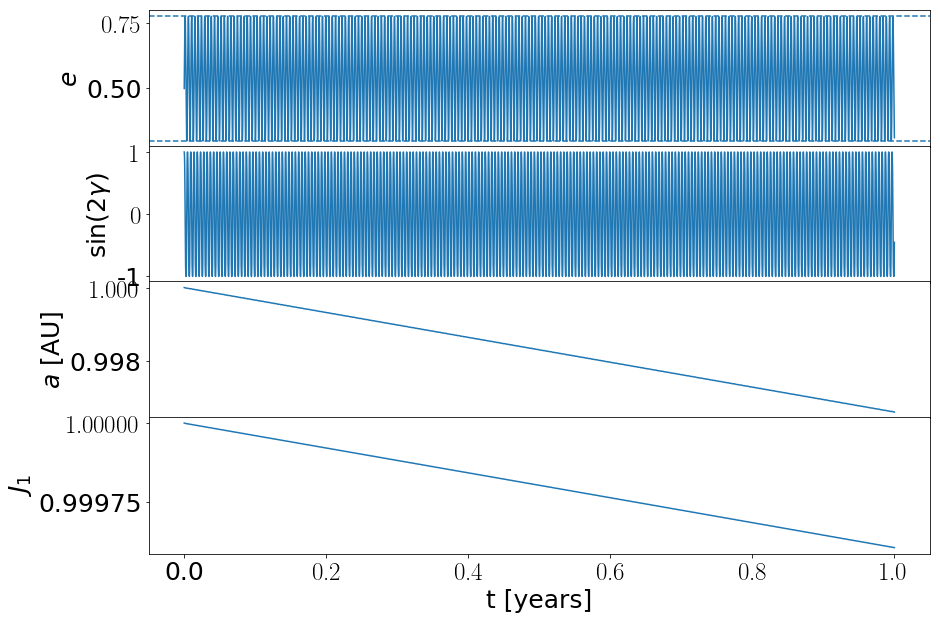

In [6]:
#Now lets compare our model with the full numerical evolution

#First load the numerical solution
numerical = np.load('../Data/NumericalSolution.npy')

#Patch to delete last entry of numerical so we have the same length for numerical and model
numerical = numerical[:-1,:]


# Now plot and compare
#plot_compare_motion(model,numerical)
plot_motion(numerical)



In [7]:
import GravRadiation as GR
constants = np.array([m0+m1, nmodes,iota,m0*m1/(m0+m1),D])
waveformNR = np.load('../Data/NumericalWaveform.npy')
#Patch 
waveformNR = waveformNR[:-1,:]
waveformAN = GR.Gwaves(model, constants)

Getting the waveform
Mode sum. n =  1.0 20.0
Mode sum. n =  2.0 20.0
Mode sum. n =  3.0 20.0
Mode sum. n =  4.0 20.0
Mode sum. n =  5.0 20.0
Mode sum. n =  6.0 20.0
Mode sum. n =  7.0 20.0
Mode sum. n =  8.0 20.0
Mode sum. n =  9.0 20.0
Mode sum. n =  10.0 20.0
Mode sum. n =  11.0 20.0
Mode sum. n =  12.0 20.0
Mode sum. n =  13.0 20.0
Mode sum. n =  14.0 20.0
Mode sum. n =  15.0 20.0
Mode sum. n =  16.0 20.0
Mode sum. n =  17.0 20.0
Mode sum. n =  18.0 20.0
Mode sum. n =  19.0 20.0
Mode sum. n =  20.0 20.0


IN
OUT
IN
OUT


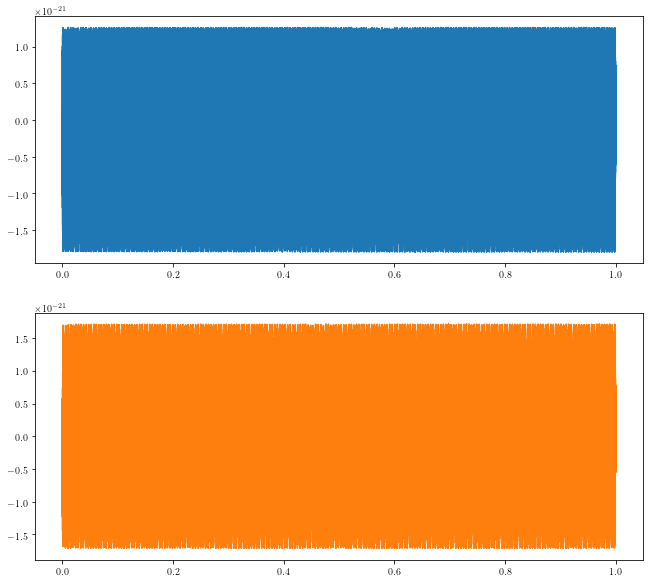

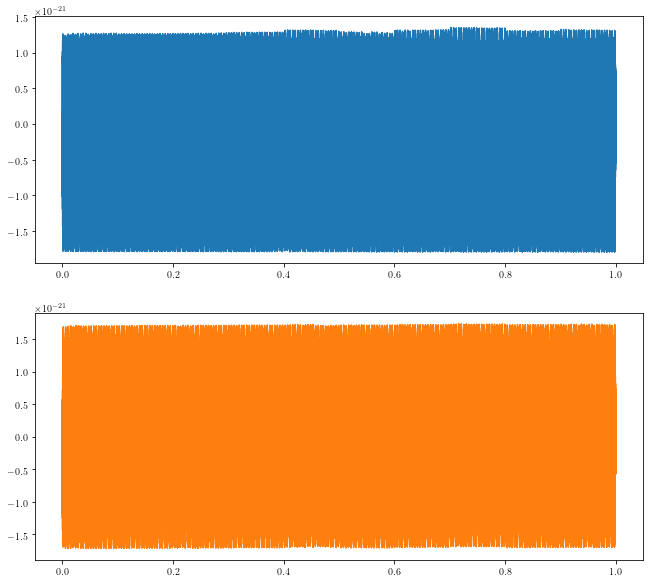

In [15]:
#Plot the GW waveforms
from plot import *
plot_GW(waveformNR,f1)
plot_GW(waveformAN,f1)
#compare_GW(waveformNR,waveformAN)

overlap =  0.987529356625819


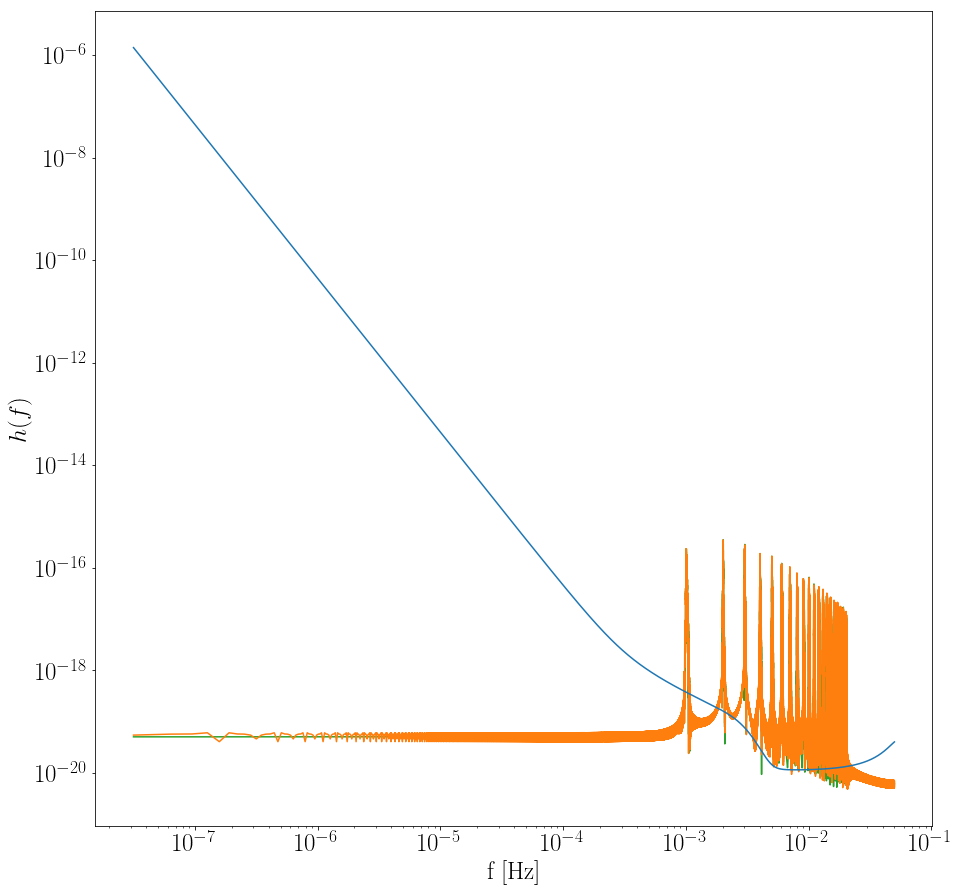

In [9]:
#Go to frequency domain and get the overlap
f,h1,h2, S = GR.overlap(waveformNR,waveformAN)
plot_GW_frequency(f,h1,h2, S)